In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=f1b766502a1dc15611fa091897cfc36befd59f3c552564eb02efb95a72ca15f5
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 39.6 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package

In [2]:
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession, Row, types as T
from pyspark.sql.functions import col, split, regexp_replace, collect_list, hash as spark_hash, concat_ws, when, abs, explode, desc, size
from pyspark.sql.types import ArrayType, StructType, StructField, StringType, LongType, DoubleType, IntegerType
from pyspark.sql.functions import udf
import numpy as np
from collections import Counter
from random import shuffle
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import MinHashLSH
import pandas as pd
from pyspark.sql import functions as F
from pyspark.sql.window import Window

In [3]:
def create_session():
    # create the session
    conf = SparkConf()
    conf.setAppName("DIS-lab-1")    # Sets name of the Spark Application
    conf.setMaster("local[16]")    # Master URL. In this case local[*] uses all the available cores in the machine
    conf.set("spark.driver.memory", "10G")   # Memory allocated to driver process
    conf.set("spark.driver.maxResultSize", "6G")    # Maximum size of results that can be returned to driver
    conf.set("spark.executor.instances", "4")
    conf.set("spark.executor.cores", "4")
    conf.set("spark.executor.memory", "4G")    # Memory allocated to each executor
    conf.set("spark.network.timeout", "600s")  # Increase network timeout
    conf.set("spark.executor.heartbeatInterval", "60s")  # Increase heartbeat interval
    conf.set("spark.rpc.message.maxSize", "512")  # Increase max message size
    conf.set("spark.driver.maxResultSize", "4G")  # Increase driver max result size
    conf.set("spark.sql.broadcastTimeout", "600")  # Increase broadcast timeout
    conf.set("spark.sql.shuffle.partitions", "200")  # Increase the number of shuffle partitions
    conf.set("spark.yarn.executor.memoryOverhead", "2048")  # Increase memory overhead
    conf.set("spark.memory.offHeap.enabled","true")
    conf.set("spark.memory.offHeap.size","10g")
    conf.set("spark.jars.packages", "graphframes:graphframes:0.8.2-spark3.0-s_2.12")  # Add GraphFrames to the spark configuration
    conf.set("spark.hadoop.fs.file.impl", "org.apache.hadoop.fs.LocalFileSystem")  # Ensure local file system is used for checkpointing

    sc = pyspark.SparkContext(conf=conf)    # Initializes the Spark context with this specific configuration
    spark = SparkSession.builder.config(conf=sc.getConf()).getOrCreate()    # Creates Spark session

    # Set checkpoint directory
    sc.setCheckpointDir("checkpoints")

    return sc, spark

try:
    if 'sc' in globals() and sc is not None:
        sc.stop()
        print("--Stopped existing SparkContext")
    if 'spark' in globals() and isinstance(spark, SparkSession):
        spark.stop()
        print("--Stopped existing SparkSession")
except Exception as e:
    print(f"Error stopping existing Spark session or context: {e}")

# Create a new Spark session
sc, spark = create_session()
print("Spark session created successfully!")
spark

Spark session created successfully!


In [4]:
logs = spark.read.csv('output2.csv', header=True, inferSchema=True)
logs = logs.dropDuplicates(['process_id'])

In [5]:
logs.limit(1).show(truncate=False)

+---+----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------+
|_c0|process_id|from_servers                  

In [6]:
logs.show(truncate=False)

+---+----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [7]:
# Split the from_servers string by comma and trim spaces
logs = logs.withColumn('servers_list', F.split(F.trim(logs['from_servers']), ',\s*'))

# Explode the servers_list column to have each server name on a new row
logs = logs.withColumn('server', F.explode('servers_list'))

# Remove any leading or trailing spaces in server names
logs = logs.withColumn('server', F.trim(logs['server']))

# Get unique server names
unique_servers = logs.select('server').distinct().rdd.map(lambda row: row[0]).collect()

# Create one-hot encoded columns for each unique server
for server in unique_servers:
    logs = logs.withColumn(server, F.when(F.array_contains(logs['servers_list'], server), 1).otherwise(0))

In [8]:
logs.limit(1).show(truncate=False)

+---+----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------

In [9]:
# Split the times column, convert to integer and sum the values
logs = logs.withColumn("sum_times",
    F.expr("aggregate(transform(split(times, ','), x -> int(trim(x))), 0, (acc, x) -> acc + x)")
)

In [10]:
final_logs = logs.select(['process_id'] + unique_servers + ['sum_times'])
final_logs = final_logs.dropDuplicates(['process_id'])

In [11]:
final_logs.limit(1).show(truncate=False)

+----------+-------------------------+--------------------------------------+---------------------+-------------------------+------------+-------------------+------------+-----------+-------------------------------------+--------------------------+-------------------------+--------------------------+-----------+-------------------------+--------------------------------------+--------------------+-----------+-------------------------+----------------------------+----------------------+--------------------------+-----------+-------------------------------------+----------------------+--------------------------------+-------------------------+------------------------------+-------------------------------------+---------------+-------------------------+--------------------------+-------------------+-------------------------+--------------------------------------+--------------------------+-----------+----------------------------+-------------------------------------+-----------+-----------

In [12]:
final_logs.show(truncate=False)

+----------+-------------------------+--------------------------------------+---------------------+-------------------------+------------+-------------------+------------+-----------+-------------------------------------+--------------------------+-------------------------+--------------------------+-----------+-------------------------+--------------------------------------+--------------------+-----------+-------------------------+----------------------------+----------------------+--------------------------+-----------+-------------------------------------+----------------------+--------------------------------+-------------------------+------------------------------+-------------------------------------+---------------+-------------------------+--------------------------+-------------------+-------------------------+--------------------------------------+--------------------------+-----------+----------------------------+-------------------------------------+-----------+-----------

In [17]:
print(final_logs.count())
print(int(final_logs.count()/3))

62
20


In [16]:
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import BisectingKMeans
import matplotlib.pyplot as plt

# Select columns for input features
cols_except_process_id = [col for col in final_logs.columns if col != 'process_id']

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=cols_except_process_id, outputCol="features")
feature_logs = assembler.transform(final_logs)

# Initialize an empty list to store silhouette scores for different k
silhouette_scores = []

# Define the range of k values to test
k_values = range(2, int(final_logs.count()/3))

# Evaluate clustering by computing silhouette score for each k
for k in k_values:
    kmeans = BisectingKMeans(k=k, seed=123)
    model = kmeans.fit(feature_logs)
    predictions = model.transform(feature_logs)

    # Evaluate the model
    evaluator = ClusteringEvaluator(featuresCol='features', predictionCol='prediction', metricName='silhouette')
    silhouette = evaluator.evaluate(predictions)
    silhouette_scores.append((k, silhouette))

# Extract the K with the highest silhouette score
optimal_k, max_silhouette = max(silhouette_scores, key=lambda x: x[1])
print(f'The optimal number of clusters is: {optimal_k} with a silhouette score of {max_silhouette}')

The optimal number of clusters is: 2 with a silhouette score of 0.7667726981841883


In [18]:
print(silhouette_scores)

[(2, 0.7667726981841883), (3, 0.5793828576977879), (4, 0.6281523334953928), (5, 0.6448342224154023), (6, 0.617805919309888), (7, 0.680942590331272), (8, 0.7190947731184507), (9, 0.7028258484205029), (10, 0.6782369513671133), (11, 0.6899781140876331), (12, 0.6835084195575879), (13, 0.6557017567250549), (14, 0.641193819934933), (15, 0.6786030256236658), (16, 0.7454389017415014), (17, 0.6960003878206922), (18, 0.7493198079419366), (19, 0.7173855413623174)]


In [ ]:
# Train the final model using the optimal k
kmeans = BisectingKMeans(k=optimal_k, seed=123)
model = kmeans.fit(feature_logs)

# Make predictions
predictions = model.transform(feature_logs)

# Show cluster centers
print("Cluster Centers:")
centers = model.clusterCenters()
for idx, center in enumerate(centers):
    print(f"Cluster {idx}: {center}")

# Show predictions
predictions.select("process_id", "prediction").show()

/usr/local/lib/python3.10/dist-packages/pyspark/ml/clustering.py:1016: FutureWarning: Deprecated in 3.0.0. It will be removed in future versions. Use ClusteringEvaluator instead. You can also get the cost on the training dataset in the summary.
  warnings.warn(


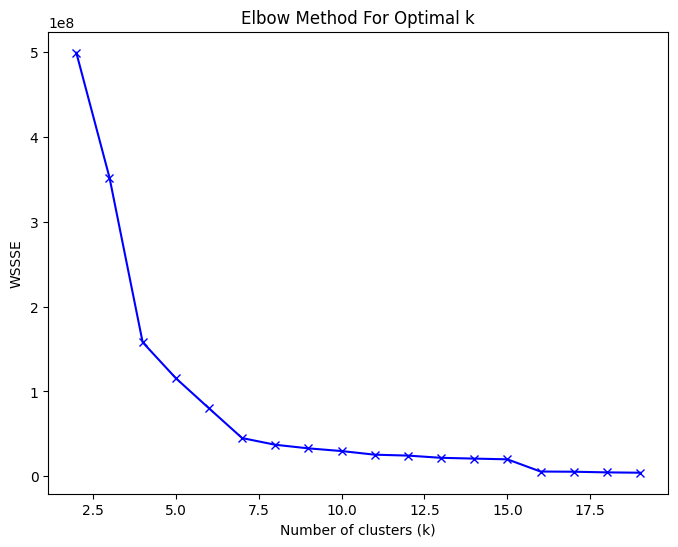

In [24]:
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import BisectingKMeans
import matplotlib.pyplot as plt
import numpy as np

# Select columns for input features
cols_except_process_id = [col for col in final_logs.columns if col != 'process_id']

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=cols_except_process_id, outputCol="features")
feature_logs = assembler.transform(final_logs)

# Initialize an empty list to store WSSSE values for different k
wssse_values = []

# Define the range of k values to test
k_values = range(2, int(final_logs.count()/3))

# Compute WSSSE for each k
for k in k_values:
    kmeans = BisectingKMeans(k=k, seed=123)
    model = kmeans.fit(feature_logs)
    wssse = model.computeCost(feature_logs)
    wssse_values.append((k, wssse))

# Extract K and WSSSE values
k_vals, wssse_vals = zip(*wssse_values)

# Plot the WSSSE values against the k values to find the elbow point
plt.figure(figsize=(8, 6))
plt.plot(k_vals, wssse_vals, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WSSSE')
plt.title('Elbow Method For Optimal k')
plt.show()

In [25]:
!pip install kneed

from kneed import KneeLocator

# Use the Kneedle algorithm to find the elbow point
kneedle = KneeLocator(k_vals, wssse_vals, curve='convex', direction='decreasing')
optimal_k = kneedle.knee
print(f'The optimal number of clusters is: {optimal_k}')

The optimal number of clusters is: 7


In [26]:
# Train the final model using the optimal k
kmeans = BisectingKMeans(k=optimal_k, seed=123)
model = kmeans.fit(feature_logs)

# Make predictions
predictions = model.transform(feature_logs)

# Show cluster centers
print("Cluster Centers:")
centers = model.clusterCenters()
for idx, center in enumerate(centers):
    print(f"Cluster {idx}: {center}")

# Show predictions
predictions.select("process_id", "prediction").show()

Cluster Centers:
Cluster 0: [1.42857143e-01 0.00000000e+00 1.42857143e-01 0.00000000e+00
 0.00000000e+00 1.42857143e-01 0.00000000e+00 1.42857143e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.42857143e-01 0.00000000e+00 0.00000000e+00 1.42857143e-01
 0.00000000e+00 4.28571429e-01 2.85714286e-01 1.42857143e-01
 4.28571429e-01 1.42857143e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.42857143e-01 1.42857143e-01
 2.85714286e-01 1.42857143e-01 0.00000000e+00 1.42857143e-01
 1.42857143e-01 0.00000000e+00 0.00000000e+00 1.42857143e-01
 7.14285714e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.85714286e-01
 2.85714286e-01 0.00000000e+00 1.42857143e-01 4.28571429e-01
 1.42857143e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.85714286e-01 1.42857143e-01 1.42857143e-01 1.42857143e-01
 0.00000000e+00 1.42857143e-01 1.42857143e-01 2.85714286e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.42857143e